# **Project Goal**

There is a data from an Audiobook App. Logically, it relates to the audio versions of books ONLY. Each customer in the database has made a purchase at least once, that's why he/she is in the database. I want to create a machine learning algorithm based on the available data that can predict if a customer will buy again from the Audiobook company.

The main idea is that if a customer has a low probability of coming back, there is no reason to spend any money on advertising to him/her. If company can focus our efforts SOLELY on customers that are likely to convert again, we can make great savings.

# **Libraries and Packages**

In [ ]:
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

# **Data Eyeballing**

There are several variables:
- `Customer ID`
- `Book length overall`: sum of the minute length of all purchases
- `Book length avg`: average length in minutes of all purchases
- `Price paid_overall`: sum of all purchases
- `Price Paid avg`: average of all purchases
- `Review`: a Boolean variable whether the customer left a review
- `Review out of 10`: if the customer left a review, his/her review out of 10
- `Total minutes listened`
- `Completion`: from 0 to 1
- `Support requests`: number of support requests
- `Last visited minus`

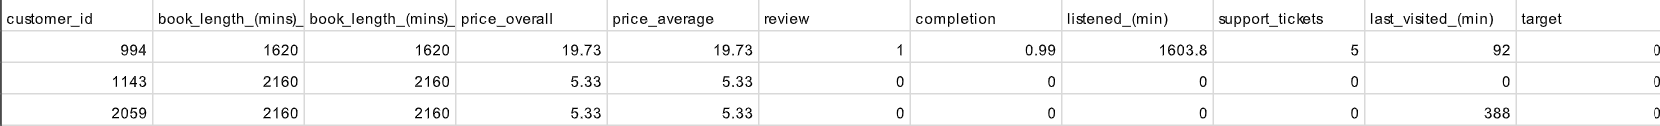

# **Load Data**

I will use the sklearn preprocessing library, as it will be easier to standardize the data.

In [ ]:
raw_csv_data = np.loadtxt('/content/drive/MyDrive/DataScience/deep/Audiobooks_data.csv',
                          delimiter = ',')

# **Segregate Target and Features**

The inputs are all columns in the csv, except for the first one which is customer ID. This columns is just the arbitrary column that bear no useful information. Also, the last one which is our targets. (1 means probaboly customer will back and 0 not).

In [ ]:
unscaled_inputs_all = raw_csv_data[:, 1:-1]
targets_all = raw_csv_data[: , -1]

# **Balance Data**

First, we should count how many targets are 1

In [ ]:
num_one_targets = int(np.sum(targets_all))
print(num_one_targets)

2237


Set a counter for targets that are 0 (meaning that the customer did not convert)

In [ ]:
zero_targets_counter = 0

I want to create a "balanced" dataset, so I will have to remove some input/target pairs. Now, I declare a variable that will do that:

In [ ]:
indices_to_remove = []

Now, I count the number of targets that are 0.  Once there are as many 0s as 1s, mark entries where the target is 0.

In [ ]:
for i in range(targets_all.shape[0]):
    if targets_all[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

Finnaly, I create two new variables, one that will contain the inputs, and one that will contain the targets. I delete all indices that were marked "to remove" in the loop above.

In [ ]:
unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all,
                                         indices_to_remove,
                                         axis=0)

targets_equal_priors = np.delete(targets_all,
                                 indices_to_remove,
                                 axis=0)

# **Standardize Data**

That's the only place I use sklearn functionality which standardizes the inputs.

In [ ]:
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)

# **Shuffle Data**

When the data was collected it was actually arranged by date. Shuffle the indices of the data, so the data is not arranged in any way when I feed it. Since I will be batching, I want the data to be as randomly spread out as possible.

In [ ]:
shuffled_indices = np.arange(scaled_inputs.shape[0])
print(shuffled_indices)

[   0    1    2 ... 4471 4472 4473]


In [ ]:
np.random.shuffle(shuffled_indices)

Now I use the shuffled indices to shuffle the inputs and targets.

In [ ]:
shuffled_inputs = scaled_inputs[shuffled_indices]

shuffled_targets = targets_equal_priors[shuffled_indices]

# **Split Data**

First I count the total number of samples

In [ ]:
samples_count = shuffled_inputs.shape[0]
print('Total sample: ', samples_count)

Total sample:  4474


Then, I count the samples in each subset, assuming I want 80-10-10 distribution of training, validation, and test.

In [ ]:
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)

print('Total train:' , train_samples_count)
print('Total val:' , validation_samples_count)

Total train: 3579
Total val: 447


The 'test' dataset contains all remaining data.

In [ ]:
test_samples_count = samples_count - train_samples_count - validation_samples_count
print('Total test:' , test_samples_count)

Total test: 448


Now, I create variables that record the inputs and targets for training. In our shuffled dataset, they are the first "train_samples_count" observations.

In [ ]:
train_inputs = shuffled_inputs[ : train_samples_count]
train_targets = shuffled_targets[ : train_samples_count]

Now, I create variables that record the inputs and targets for validation They are the next "validation_samples_count" observations, folllowing the "train_samples_count" I already assigned.

In [ ]:
validation_inputs = shuffled_inputs[train_samples_count : train_samples_count + validation_samples_count]
validation_targets = shuffled_targets[train_samples_count : train_samples_count + validation_samples_count]

Finnaly, I create variables that record the inputs and targets for test They are everything that is remaining.

In [ ]:
test_inputs = shuffled_inputs[train_samples_count + validation_samples_count : ]
test_targets = shuffled_targets[train_samples_count + validation_samples_count : ]

Finnaly, I print the number of targets that are 1s, the total number of samples, and the proportion for training, validation, and test.


In [ ]:
print("Number of target One in training is {}, and this dataset has {} rows. So, {}% of customer are liekly to come back".format(np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count))
print("Number of target One in validation is {}, and this dataset has {} rows. So, {}% of customer are liekly to come back".format(np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count))
print("Number of target One in test is {}, and this dataset has {} rows. So, {}% of customer are liekly to come back".format(np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count))

Number of target One in training is 1782.0, and this dataset has 3579 rows. So, 0.4979044425817267% of customer are liekly to come back
Number of target One in validation is 232.0, and this dataset has 447 rows. So, 0.5190156599552572% of customer are liekly to come back
Number of target One in test is 223.0, and this dataset has 448 rows. So, 0.49776785714285715% of customer are liekly to come back


It shows we have balanced dataset now.

# **Prepare Data**

I should ensure that features all floats. Target must be int, because later I use sparse categorical crossentropy for doing one-hot encoding.

In [ ]:
train_inputs = train_inputs.astype(float)
train_targets = train_targets.astype(int)

I also do the same for validation and test;

In [ ]:
validation_inputs, validation_targets = validation_inputs.astype(float), validation_targets.astype(int)

In [ ]:
test_inputs, test_targets = test_inputs.astype(float), test_targets.astype(int)

# **Model Training**

First, we should set dimension of output and input:

In [ ]:
input_size = 10
output_size = 2

I use 50 hidden layer size for both hidden layers.

In [ ]:
hidden_layer_size = 50

Now I define how the model will look like:

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer and use softmax because we have binary problem.
])

Then, I choose the optimizer and the loss function. I define the optimizer and the metrics I am interested in obtaining at each iteration

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #We need to one-hot encode data
              metrics=['accuracy'])

Now, it's time to set batch size and number of epoch:

In [ ]:
batch_size = 50
max_epochs = 200

Also, for preventing overfitting, I set earlystopping with patience 2. In this case I am a bit tolerant against random validation loss increases

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

And last step is fit and run the model:

In [ ]:
model.fit(train_inputs, # train inputs
          train_targets, # train targets
          batch_size = batch_size, # batch size
          epochs = max_epochs, # epochs that we will train for
          callbacks = [early_stopping], # early stopping
          validation_data = (validation_inputs, validation_targets), # validation data
          verbose = 2 # making sure we get enough information about the training process
          )

Epoch 1/200
72/72 - 1s - 11ms/step - accuracy: 0.8164 - loss: 0.3351 - val_accuracy: 0.7987 - val_loss: 0.3586
Epoch 2/200
72/72 - 1s - 17ms/step - accuracy: 0.8259 - loss: 0.3319 - val_accuracy: 0.8121 - val_loss: 0.3471
Epoch 3/200
72/72 - 0s - 5ms/step - accuracy: 0.8189 - loss: 0.3335 - val_accuracy: 0.8121 - val_loss: 0.3464
Epoch 4/200
72/72 - 1s - 7ms/step - accuracy: 0.8145 - loss: 0.3357 - val_accuracy: 0.8054 - val_loss: 0.3483
Epoch 5/200
72/72 - 0s - 3ms/step - accuracy: 0.8240 - loss: 0.3330 - val_accuracy: 0.8054 - val_loss: 0.3586


# **Test Model**

In training we get 82% accuracy in training and 80% accuracy in validation. Now, we can test it.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_inputs,
                                          test_targets)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8089 - loss: 0.3713 


In [ ]:
print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.35. Test accuracy: 82.14%


Note that each time the code is rerun, we get a different accuracy because each training is different.

We have intentionally reached a suboptimal solution, so you can have space to build on it!